In [1]:
from tqdm import tqdm
import torch
import torch.nn as nn
import torch.nn.functional as F
import pickle
import numpy as np
import random
from pizzairnet import PizzairNet, ResidualBlock
from imitation_learning_dataloader import ImitationDataLoader

# training configuration

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
#pizzair_model = PizzairNet(ResidualBlock, [3, 4, 6, 3])


# data loading

video_list_wd2 = ['wd2_brown',
                  'wd2_city1',
                  'wd2_city2',
                  'wd2_office',
                  'wd2_park1',
                  'wd2_park2']
video_list_fh4 = ['fh4_edin',
                  'fh4_park',
                  'fh4_quarry',
                  'fh4_train',
                  'fh4_tree']
video_list_mix = ['wd2_city1', # random mix of the two data sets 
                  'wd2_office',
                  'wd2_park2',
                  'fh4_edin',
                  'fh4_train',
                  'fh4_tree']
video_list_test_wd2 = ['wd2_sub']
video_list_real = ['real_south']

vid_list_all_sim = video_list_wd2 + video_list_fh4
vid_list_all = video_list_wd2 + video_list_fh4 + video_list_test_wd2 + video_list_real

In [2]:
batch_size = 128

pizzair_model = PizzairNet(ResidualBlock, [2,2,2,2])
pizzair_model.to(device)
num_epochs = 150
optimizer = torch.optim.AdamW(pizzair_model.parameters(),lr=5e-4)

training_losses = np.zeros(num_epochs)

for epoch in range(num_epochs):
    # training
    pizzair_model.train()
    t_loss = 0.0
    t_num_correct = 0
    # need to "remake" it because it doens't reset as of now. oops 
    #imitation_train_dataset = ImitationDataLoader(video_name_list=video_list_real,batch_size=batch_size)
    imitation_train_dataset = ImitationDataLoader(video_name_list=vid_list_all,batch_size=batch_size)

    for X_train_batch,Y_train_batch in tqdm(imitation_train_dataset,desc='Epoch: '+str(epoch+1)):
    #print('Epoch: '+str(epoch+1))
    #for X_train_batch,Y_train_batch in imitation_train_dataset:
        
        # puts on GPU
        X_train_batch = X_train_batch.to(device)
        Y_train_batch = Y_train_batch.to(device)
        
        optimizer.zero_grad()
        Y_train_hat = pizzair_model(X_train_batch)
        #print(Y_train_hat)
        #print(Y_train_batch)
        loss = pizzair_model.loss(Y_train_hat,Y_train_batch,epoch)
        loss.backward()
        optimizer.step()
        t_loss += loss.item()

    training_losses[epoch]   = t_loss/(imitation_train_dataset.__len__()*batch_size)
torch.save(pizzair_model,'models/model_v3' +  '.pth')


c:\Users\qtcc\miniconda3\envs\rl\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Epoch: 150: 100%|██████████| 408/408 [02:24<00:00,  2.82it/s]


In [3]:
torch.save(pizzair_model,'models/model_v2_all' +  '.pth')


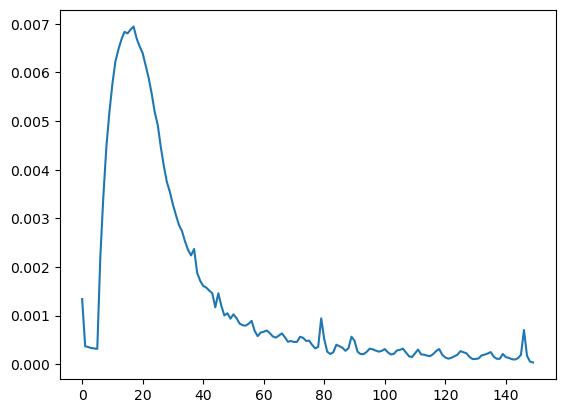

In [3]:
import matplotlib.pyplot as plt
plt.plot(range(len(training_losses)),training_losses)

In [7]:
### Fine-tuning script ### 
batch_size = 128

pizzair_model = torch.load('models/model_v2_all' +  '.pth')
pizzair_model.to(device)
num_epochs = 20
optimizer = torch.optim.AdamW(pizzair_model.parameters(),lr=1e-4)

training_losses = np.zeros(num_epochs)

for epoch in range(num_epochs):
    # training
    pizzair_model.train()
    t_loss = 0.0
    t_num_correct = 0
    # need to "remake" it because it doens't reset as of now. oops 
    imitation_train_dataset = ImitationDataLoader(video_name_list=video_list_real,batch_size=batch_size)

    for X_train_batch,Y_train_batch in tqdm(imitation_train_dataset,desc='Epoch: '+str(epoch+1)):
        # puts on GPU
        X_train_batch = X_train_batch.to(device)
        Y_train_batch = Y_train_batch.to(device)
        
        optimizer.zero_grad()
        Y_train_hat = pizzair_model(X_train_batch)
        #print(Y_train_hat)
        #print(Y_train_batch)
        loss = pizzair_model.loss(Y_train_hat,Y_train_batch,epoch+100)
        loss.backward()
        optimizer.step()
        t_loss += loss.item()

    training_losses[epoch]   = t_loss/(imitation_train_dataset.__len__()*batch_size)
torch.save(pizzair_model,'models/model_v2_all_ft' +  '.pth')


Epoch: 20: 100%|██████████| 16/16 [00:04<00:00,  3.34it/s]


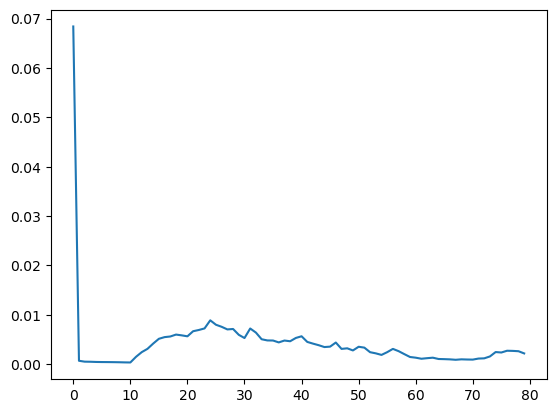

In [14]:
# plots training loss stuff
import matplotlib.pyplot as plt
plt.plot(range(len(training_losses)),training_losses)
np.save('train_loss_record.npy',training_losses)

In [16]:
# eval script

models_to_evaluate = ['model_v2_real.pth',
                      'model_v2_all.pth',
                      'model_v2_all_ft.pth',
                      'model_v2_wd2.pth',
                      'model_v2_fh4.pth',
                      'model_v2_mix.pth']
for model in models_to_evaluate:
    # resets dataloaders... yeah
    test_sim_dataset = ImitationDataLoader(video_name_list=video_list_test_wd2,batch_size=batch_size)
    test_real_dataset = ImitationDataLoader(video_name_list=video_list_real,batch_size=batch_size)
    test_all_dataset = ImitationDataLoader(video_name_list=vid_list_all,batch_size=batch_size)
    print('***' + model + '***')
    pizzair_model = torch.load('models/' + model)
    pizzair_model.to(device)
    pizzair_model.eval()
    sim_test_loss = 0.0
    real_test_loss = 0.0
    all_loss = 0.0
    y_true = []
    y_pred = []
    with torch.inference_mode():
        # Loop for Test Sim
        for X_train_batch,Y_train_batch in test_sim_dataset:
            X_train_batch = X_train_batch.to(device)
            Y_train_batch = Y_train_batch.to(device)
            Y_train_hat = pizzair_model(X_train_batch)
            loss = pizzair_model.loss(Y_train_hat,Y_train_batch,50)
            #optimizer.step()
            sim_test_loss += loss.item()
        print('Test Sim Loss:',sim_test_loss/(test_sim_dataset.__len__()*batch_size))
        # Loop for Test Real
        for X_train_batch,Y_train_batch in test_real_dataset:
            X_train_batch = X_train_batch.to(device)
            Y_train_batch = Y_train_batch.to(device)
            Y_train_hat = pizzair_model(X_train_batch)
            loss = pizzair_model.loss(Y_train_hat,Y_train_batch,50)
            real_test_loss += loss.item()
        print('Test Real Loss:',real_test_loss/(test_real_dataset.__len__()*batch_size))
        # Loop for All
        for X_train_batch,Y_train_batch in test_all_dataset:
            X_train_batch = X_train_batch.to(device)
            Y_train_batch = Y_train_batch.to(device)
            Y_train_hat = pizzair_model(X_train_batch)
            loss = pizzair_model.loss(Y_train_hat,Y_train_batch,50)
            all_loss += loss.item()
        print('All Loss:',all_loss/(test_all_dataset.__len__()*batch_size))


***model_v2_real.pth***
Test Sim Loss: 0.0567758587976208
Test Real Loss: 0.012792560213711113
All Loss: 0.04123704235911753


Exception ignored in: <function VideoLoader.__del__ at 0x000002921B963A60>
Traceback (most recent call last):
  File "c:\Users\qtcc\miniconda3\envs\rl\Lib\site-packages\decord\video_loader.py", line 62, in __del__
    _CAPI_VideoLoaderFree(self._handle)
  File "c:\Users\qtcc\miniconda3\envs\rl\Lib\site-packages\decord\_ffi\_ctypes\function.py", line 173, in __call__
    check_call(_LIB.DECORDFuncCall(
               ^^^^^^^^^^^^^^^^^^^^
KeyboardInterrupt: 


***model_v2_all.pth***
Test Sim Loss: 0.01635358749089868


In [3]:
torch.save(pizzair_model,'models/pizzairnet_v1_1_0.pth')